Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [63]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import matplotlib.pyplot as plt

import os
import math
import random
import tensorflow as tf
import collections
import numpy as np
import zipfile

from tqdm import tqdm
from six.moves import range
from IPython import display
from matplotlib import pylab
from itertools import compress
from sklearn.manifold import TSNE
from scipy.spatial import distance
from __future__ import print_function
from six.moves.urllib.request import urlretrieve

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 75000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 271527], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch_cbow(batch_size, num_skips, skip_window):

    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span) # used for collecting data[data_index] in the sliding window
    # collect the first window of words
    
    for _ in range(span):
            buffer.append(data[data_index])
            data_index = (data_index + 1) % len(data)
        # move the sliding window
        
    for i in range(batch_size):
            mask = [1] * span
            mask[skip_window] = 0 
            batch[i, :] = list(compress(buffer, mask)) # all surrounding words
            labels[i, 0] = buffer[skip_window] # the word at the center 
            buffer.append(data[data_index])
            data_index = (data_index + 1) % len(data)
            
    return batch, labels
    
def generate_batch_skipgram(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span) # used for collecting data[data_index] in the sliding window
    for _ in range(span):
            buffer.append(data[data_index])
            data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
            target = skip_window  # target label at the center of the buffer
            targets_to_avoid = [ skip_window ]
            for j in range(num_skips):
                while target in targets_to_avoid:
                    target = random.randint(0, span - 1)
                targets_to_avoid.append(target)
                batch[i * num_skips + j] = buffer[skip_window]
                labels[i * num_skips + j, 0] = buffer[target]
            buffer.append(data[data_index])
            data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch_skipgram(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'a', 'term', 'originated', 'term', 'as', 'originated', 'of']


## Train a skip-gram model.

In [7]:
architecture = 'SKIP'

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

if architecture == 'CBOW':
    input_shape = [batch_size, num_skips]
    generate_batch = generate_batch_cbow
elif architecture == 'SKIP':
    input_shape = [batch_size]
    generate_batch = generate_batch_skipgram


graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=input_shape)
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  if architecture == 'SKIP':
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
  elif architecture == 'CBOW':
    emb = tf.zeros([batch_size, embedding_size])
    for j in range(num_skips):
        emb += tf.nn.embedding_lookup(embeddings, train_dataset[:, j])
    embed = emb

  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                                   train_labels, num_sampled, vocabulary_size))  

    
  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Average loss at step 200000: 3.196384


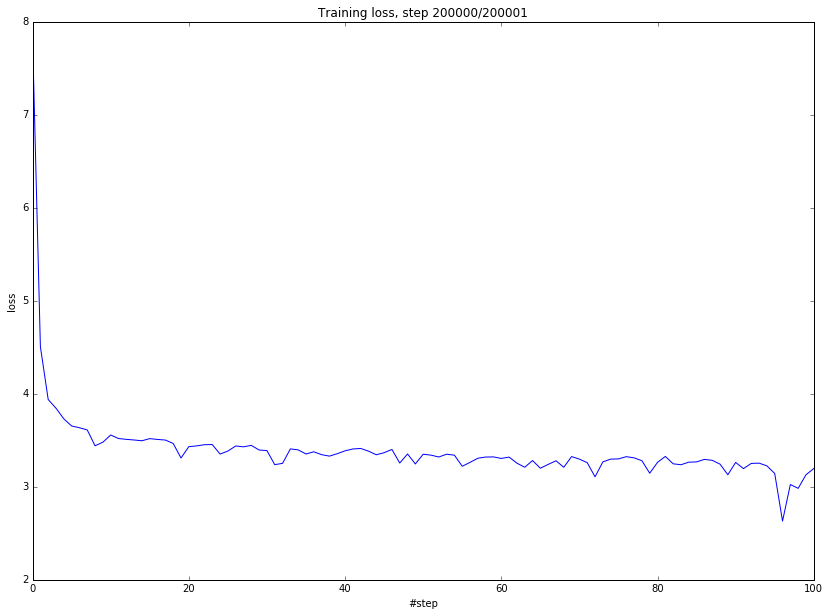

Nearest to when: if, though, although, where, while, before, after, until,
Nearest to that: which, however, what, heighten, where, but, this, nevertheless,
Nearest to were: are, have, was, while, those, been, had, be,
Nearest to such: well, these, many, known, serve, certain, those, including,
Nearest to state: government, states, leadership, territory, geodesic, burrus, custody, candidates,
Nearest to and: or, but, nor, however, including, while, which, leveraging,
Nearest to into: through, within, inside, further, schreibmax, under, across, cession,
Nearest to more: less, most, very, rather, fairly, quite, greater, increasingly,
Nearest to two: three, four, five, six, seven, one, isbn, zero,
Nearest to may: might, should, can, must, could, would, will, cannot,
Nearest to during: after, despite, throughout, around, before, in, at, until,
Nearest to this: which, it, another, the, what, some, mardi, cady,
Nearest to use: support, practice, lydon, allow, undeniably, beasley, way, forefro

In [8]:
num_steps = 200001
lh = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
        
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
    average_loss += l
    
    if step % 2000 == 0:
      display.clear_output(wait=True)
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      lh.append(average_loss)
      average_loss = 0
            
      plt.figure(figsize=(14, 10))

      plt.title("Training loss, step {}/{}".format(step, num_steps))
      plt.xlabel("#step")
      plt.ylabel("loss")
      plt.plot(lh, 'b')
      plt.show()
      

    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
        
  final_embeddings = normalized_embeddings.eval()

In [11]:
num_points = 400

SKIP_EMB = final_embeddings

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

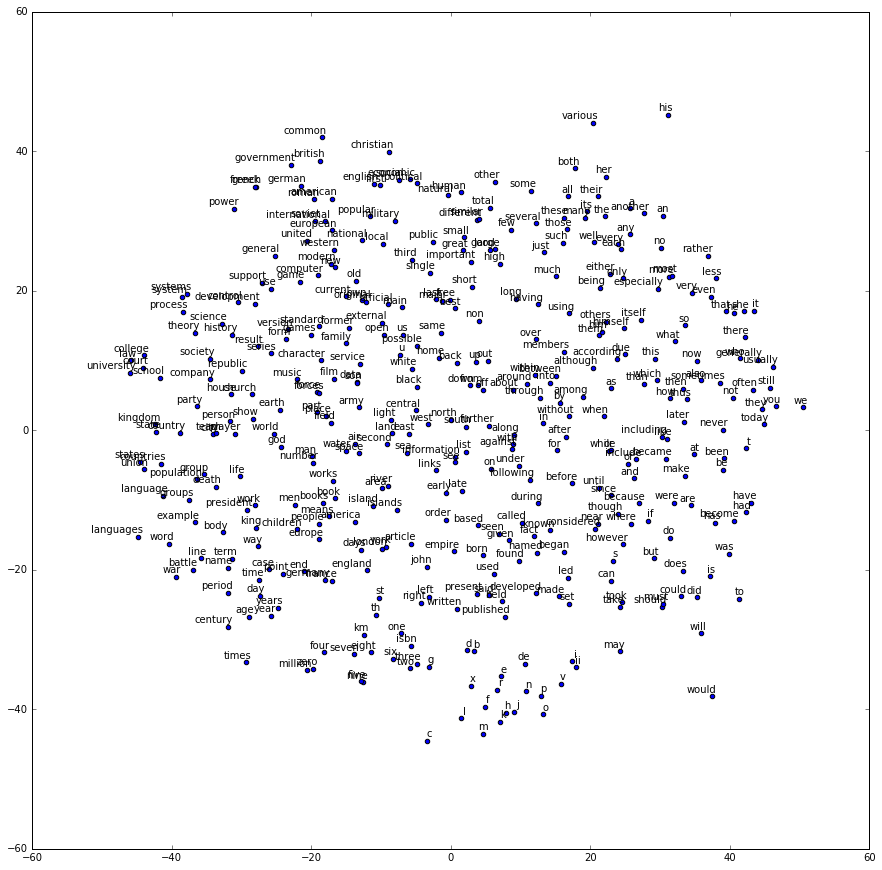

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [12]:
architecture = 'CBOW'

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.

valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

if architecture == 'CBOW':
    input_shape = [batch_size, num_skips]
    generate_batch = generate_batch_cbow
elif architecture == 'SKIP':
    input_shape = [batch_size]
    generate_batch = generate_batch_skipgram


graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=input_shape)
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  if architecture == 'SKIP':
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
  elif architecture == 'CBOW':
    emb = tf.zeros([batch_size, embedding_size])
    for j in range(num_skips):
        emb += tf.nn.embedding_lookup(embeddings, train_dataset[:, j])
    embed = emb

  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                                                   train_labels, num_sampled, vocabulary_size))  

  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Average loss at step 200000: 2.421071


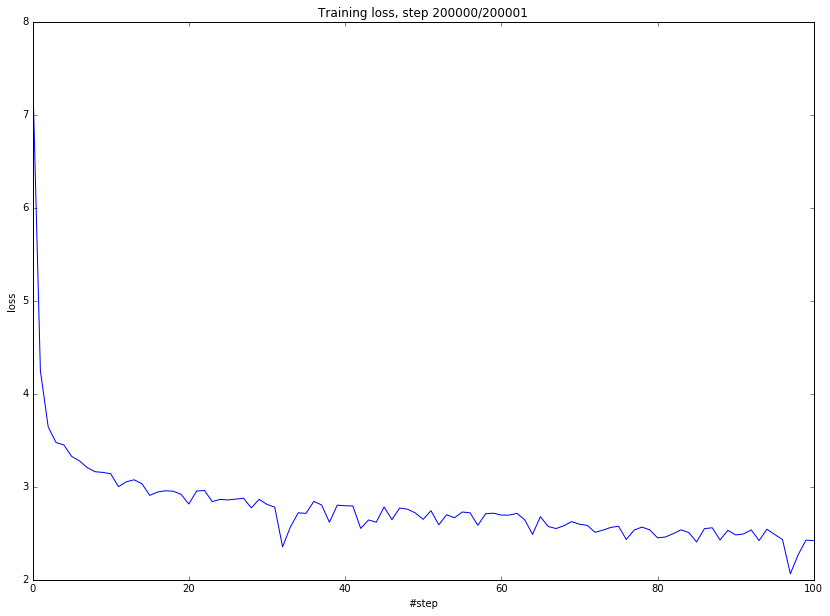

Nearest to see: includes, include, references, refers, consider, external, rulership, tell,
Nearest to called: named, referred, termed, known, responsible, intended, described, used,
Nearest to of: including, kassites, boggy, huacaya, pagoda, meroitic, in, lrc,
Nearest to two: three, four, five, six, seven, eight, one, zero,
Nearest to use: usage, allow, cause, support, switchable, share, grant, practice,
Nearest to were: are, was, have, include, had, contain, kannon, remain,
Nearest to its: their, his, her, whose, the, our, sarabande, hollowed,
Nearest to state: provincial, states, government, ruler, republic, confidence, territory, zep,
Nearest to many: several, some, numerous, various, most, few, those, both,
Nearest to five: six, seven, four, eight, three, two, nine, zero,
Nearest to new: kyi, previous, crammed, different, boomerang, mam, transitional, whig,
Nearest to no: little, any, nothing, resh, circumcising, manifestos, compiles, ekelund,
Nearest to world: francisco, dealloca

In [14]:
num_steps = 200001
lh = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
        
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    
    average_loss += l
    
    if step % 2000 == 0:
      display.clear_output(wait=True)
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      lh.append(average_loss)
      average_loss = 0
            
      plt.figure(figsize=(14, 10))

      plt.title("Training loss, step {}/{}".format(step, num_steps))
      plt.xlabel("#step")
      plt.ylabel("loss")
      plt.plot(lh, 'b')
      plt.show()
      

    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
        
  final_embeddings = normalized_embeddings.eval()

In [15]:
num_points = 400

CBOW_EMB = final_embeddings

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

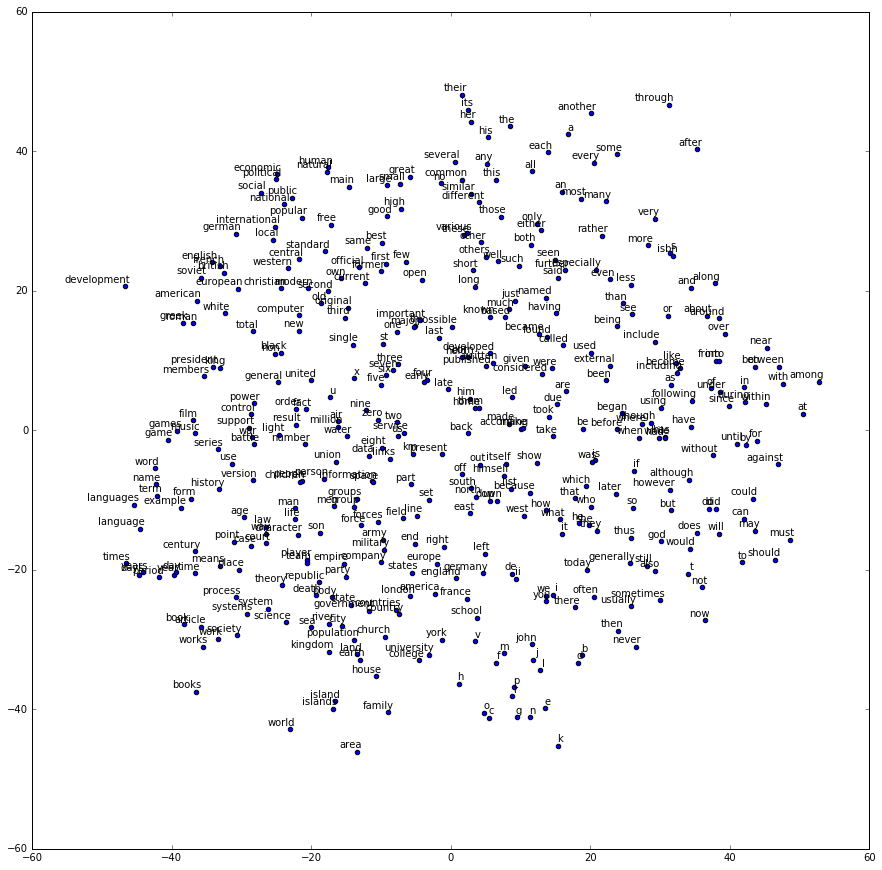

In [16]:
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

## BONUS ROUND!

In [101]:
dr = '../../Oracle/topics'
topics = {}
for d in ['space', 'jobs', 'countries', 'food']: #os.listdir(dr):
    with open(os.path.join(dr, d)) as f:
        l = f.readlines()
        topics[d] = [s.strip().lower() for s in l if len(s.strip())>2]

In [102]:
topics['countries'][:5]

['afghanistan', 'albania', 'algeria', 'andorra', 'angola']

In [103]:
topics['space'][-5:]

['wormhole', 'x-rays', 'yellow dwarf', 'zenith', 'zodiac']

In [70]:
def word_to_vec(st, mod, rd, verbose=False):
    fl = 0
    WM = np.zeros((mod.shape[1],))
    words = st.split()
    for w in words:
        try:
            wi = mod[rd[w]]
            WM += wi
            fl += 1
        except Exception as e:
            if verbose: print(e)
    return float(fl)/len(words), WM

In [89]:
colors = ['r', 'g', 'b', 'GoldenRod']

tw = {}
for i, k in enumerate(topics):
    for w in topics[k]:
        wr = word_to_vec(w, CBOW_EMB, dictionary)
        if wr[0] > 0.8:
            tw[w] = {'topic': k, 'color': colors[i], 'repr': wr[1]}

In [90]:
M = np.array([tw[k]['repr'] for k in tw])
labels = [k.decode('unicode_escape') for k in tw]
colors = [tw[k]['color'] for k in tw]

In [91]:
P = distance.squareform(distance.pdist(M, metric='cosine'))
tsne2 = TSNE(n_components=2, random_state=34, metric='precomputed', n_iter=9001)
Y2 = tsne2.fit_transform(P)

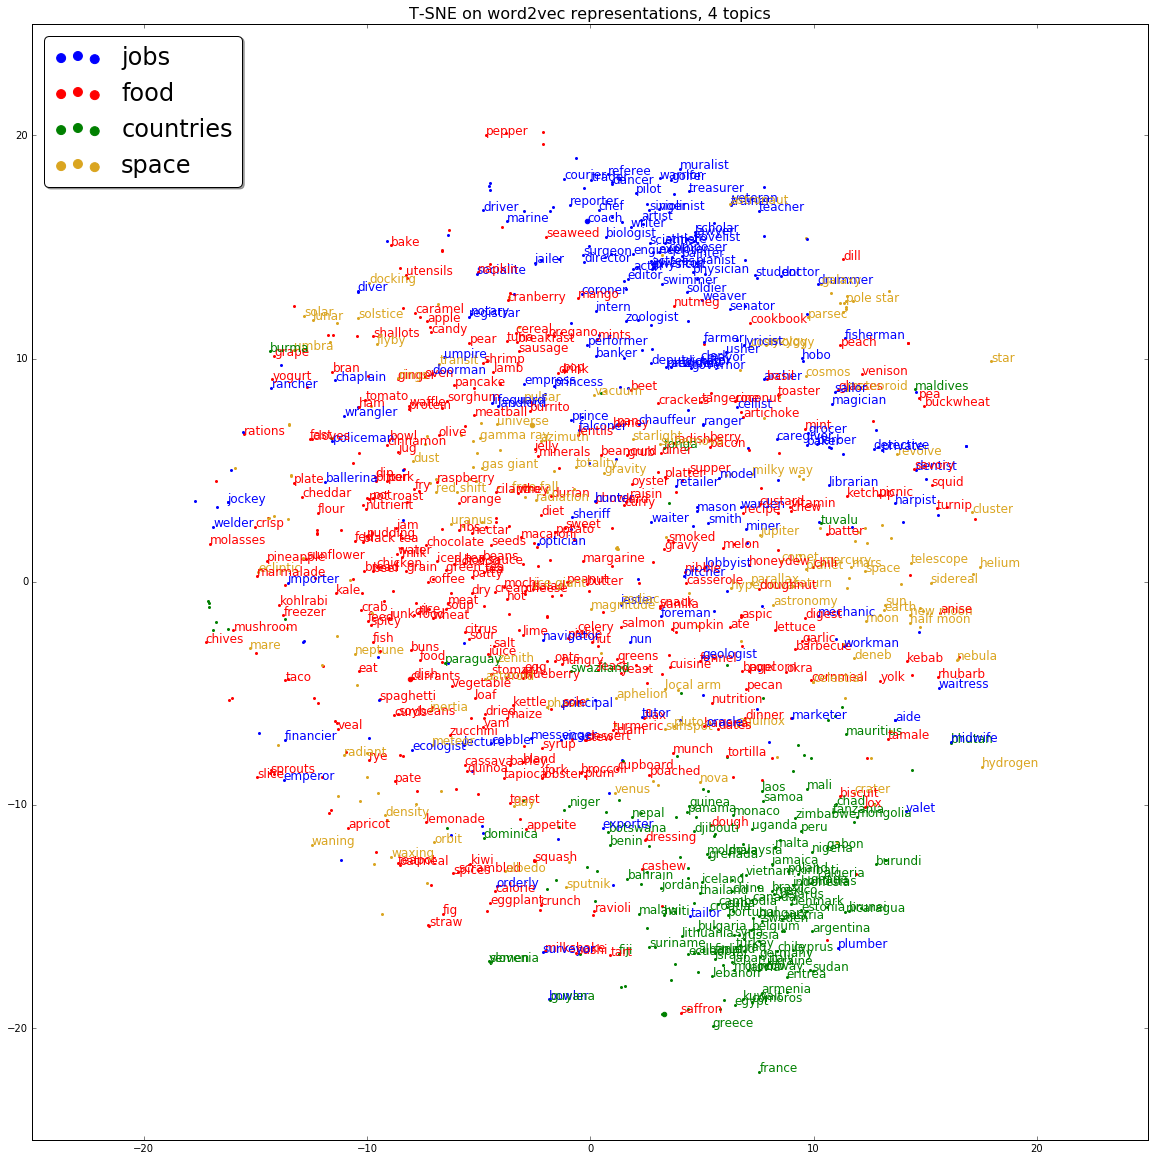

In [95]:
TH = 0.75
Y = Y2
U = {k:0 for k in topics}
plt.figure(figsize=(20,20))
for i, k in enumerate(tw):
    if not U[tw[k]['topic']]:
        U[tw[k]['topic']] = 1
        plt.scatter([Y[i][0]], [Y[i][1]], color = tw[k]['color'], label=tw[k]['topic'])
    else:
        plt.scatter([Y[i][0]], [Y[i][1]], color = tw[k]['color'], s=4)
    
for label, clr, x, y in zip(labels, colors, Y[:, 0], Y[:, 1]):
    if random.random() > 1 - TH and len(label) < 10:
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', color=clr, fontsize=12)
        
    
plt.xlim([-25, 25])
plt.ylim([-25, 25])

plt.title('T-SNE on word2vec representations, 4 topics', fontsize=16)        
plt.legend(loc='upper left', shadow=True, fancybox=True, markerscale=2, fontsize=24)
#plt.savefig('figures/w2v_3.eps', format = 'eps')
plt.show()